### Imports

In [1]:
import os
import sys
# Set project root
project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(project_root)

import pandas as pd

import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.preprocessing import MinMaxScaler

from datetime import datetime

#--- Get absolute path to the utils folder---
from pathlib import Path
utils_path = Path.cwd() / "utils"
sys.path.append(str(utils_path))

backtesting_path = Path.cwd() / "backtesting"
sys.path.append(str(backtesting_path))

from notebooks.utils.config_utils import load_config
from notebooks.utils.data_utils import load_dataset, preprocess_data
from notebooks.utils.model_utils import initialise_model, grid_search, get_feature_importance, optimise_threshold
from notebooks.utils.plotting_utils import plot_correlation, plot_scatter, plot_roc_and_prc, plot_classification_report, plot_point_biserial_correlation
from notebooks.utils.pdf_utils import create_markdown_report, update_markdown_with_model_details, convert_markdown_to_html, save_pdf_from_html

from notebooks.backtesting.backtester import Backtester

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

import numpy as np

### Load config.yaml

In [2]:
# Test load
config = load_config("config_trailing.yaml")

Config loaded successfully!


### Load the dataset

In [3]:
df = load_dataset(config)
df_selected, selected_features, constructed_features, target_variable = preprocess_data(df, config)

df_selected

📁 Dataset Loaded: 3639 rows, 101 columns
✅ Dataset Preprocessed: 3416 rows, 31 columns


,id_odsp,date,season,league,country,home_team,away_team,score_pre_80,score_ft,leading_team_corners_70_75,...,trailing_team_shot_to_corner_ratio_pre_80,leading_team_shot_to_corner_ratio_pre_80,trailing_team_aggression_score_pre_80,leading_team_aggression_score_pre_80,leading_team_urgency_to_attack,trailing_team_urgency_to_attack,leading_team_momentum_to_attack,trailing_team_momentum_to_attack,trailing_team_probability,target
0,Aw5DflLH/,2011-08-06,2012,D1,germany,FC Augsburg,SC Freiburg,1-2,2-2,0,...,2.250,2.667,1.556,3.125,0.294,0.424,-0.294,-0.424,42.373,1
1,CzPV312a/,2011-08-06,2012,F1,france,Paris Saint-Germain,Lorient,0-1,0-1,0,...,2.750,1.800,1.727,0.667,0.106,0.645,-0.106,1.935,64.516,2
2,GUOdmtII/,2011-08-06,2012,F1,france,Caen,Valenciennes,1-0,1-0,0,...,1.250,4.500,1.000,1.000,0.400,0.290,0.000,0.000,28.986,2
3,Wn69eU5B/,2011-08-06,2012,D1,germany,FC Cologne,VfL Wolfsburg,0-1,0-3,0,...,1.000,4.667,1.857,1.286,0.394,0.333,-0.788,0.333,33.333,0
4,bkjpaC6n/,2011-08-06,2012,D1,germany,Werder Bremen,Kaiserslautern,1-0,2-0,1,...,1.500,2.833,4.167,0.647,0.546,0.208,1.092,-0.208,20.833,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3634,r5V5rw33/,2017-01-22,2017,E0,england,Arsenal,Burnley,1-0,2-1,0,...,2.500,2.333,1.100,0.381,0.813,0.056,0.813,-0.224,5.634,0
3635,r5m8MY4G/,2017-01-22,2017,D1,germany,Bayer Leverkusen,Hertha Berlin,2-1,3-1,0,...,2.000,2.000,2.500,0.917,0.549,0.175,0.000,-0.175,17.544,0
3636,trUaUcuk/,2017-01-22,2017,SP1,spain,Osasuna,Sevilla,2-3,3-4,0,...,4.000,1.833,1.083,0.909,0.633,0.147,0.633,0.000,14.706,0
3637,xSU9scI9/,2017-01-22,2017,E0,england,Chelsea,Hull,1-0,2-0,0,...,1.143,0.875,1.500,1.571,0.840,0.050,0.000,0.050,5.000,0


# Classification Pipeline

- **Feature Selection**: 
    - Trains only on selected and constructed features
- **Data Splitting**:
    - Exclude the last 500 rows for testing
    - Split remaining data into 80% train and 20% validation sets
- **Model Training Loop**:
    1) Initialise each model from config yaml
    2) Apply MinMax scaling... *only for models that require scaling*
    3) Perform grid search for hyperparameter tuning (if specified) and Train Model
    4) Predict on validation set and display feature importance
    5) Optimise precision-recall threshold
    6) Evaluate model on validation set using optimised threshold
    7) Plot ROC and Precision-Recall graphs
    8) Predict on the test set (last 500 rows) and evaluate
    9) Save the trained model
    10) Save predictions (for backtesting).
    11) Plot Scatter Graph.

In [4]:
def run_regression_pipeline(config, df, selected_features, constructed_features, target_variable, show_output=False, generate_pdf=False): 
    models_to_train = config['model']['regression']['models']
    
    # # Step 1: Create the Markdown for the report
    # if generate_pdf:
    #     markdown_content = create_markdown_report(config, feature_correlation_image_path, target_variable, selected_features, constructed_features, models_to_train)   
    
    # Only train on selected and constructed features
    X = df[selected_features + constructed_features]
    y = df[target_variable]

    # Split data to exclude the last 500 rows for testing
    train_data = df.iloc[:-500]
    test_data = df.iloc[-500:]

    # Split data -> train & validation
    X_train, X_val, y_train, y_val = train_test_split(
        train_data[selected_features + constructed_features],
        train_data[target_variable],
        test_size=0.2,
        random_state=42
    )

    # Create X and y for testset
    X_test= test_data[selected_features+constructed_features]
    y_test = test_data[target_variable]

    # MinMax Scaling for models that require scaling...
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)

    # --- MODEL TRAINING LOOP ---
    for model_name in models_to_train:
        print(f"\n-> Training {model_name}...")

        # Get the hyperparameters for the model
        hyperparameters = config["model"]["regression"]["hyperparameters"].get(model_name, {})
        do_grid_search = config["model"]["regression"].get("grid_search", False)
        
        # Initialize the model
        model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
        model.fit(X_train, y_train)

        # --- STEP 4: Predict on the validation set ---
        y_pred_val = model.predict(X_val)
        # y_pred_val = np.round(y_pred_val, 3)

        accuracy = accuracy_score(y_val, y_pred_val)
        print(f"Accuracy: {accuracy}")

        # #Calc probabilities and implied odds for each prediction...
        # prob_at_least_1=[probability_at_least_one_corner(pred) for pred in y_pred_val]
        # implied_odds_list =[implied_odds(pred) for pred in y_pred_val]

        # #Measures to eval model performnce:
        # mae= mean_absolute_error(y_val,y_pred_val)
        # mse =mean_squared_error(y_val, y_pred_val)
        # rmse= mse**0.5

        # print("\n### Model Performance ###")
        # print(f"Mean Absolute Error (MAE): {mae:.4f}")
        # print(f"Mean squared Error (MSE): {mse:.4f}")
        # print(f"Root Mean Squared error (RMSE): {rmse:.4f}")

        # #Create a df with features, actual corner difference, and predictions
        # # pred_df =X_val.copy()
        # # pred_df['corner_diff'] = y_val.values 
        # # pred_df['y_pred'] = y_pred_val
        # # pred_df['prob_at_least_1_corner'] =prob_at_least_1
        # # pred_df['implied_odds'] = implied_odds_list
        # # print(pred_df.head())

        #--------------- TEST SET -----------------

        y_pred_test = model.predict(X_test)

        # # --- STEP 8: Save Predictions ---
        prediction_file = f"../data/predictions/{model_name.replace(' ', '_').lower()}_multi_class_predictions.csv"
        results_df = pd.DataFrame({
            'kaggle_id': test_data['id_odsp'],
            'model_predicted_binary': y_pred_test>=2,
            'actual_result': (y_test>0)
        })
        results_df.to_csv(prediction_file, index=False)
        if show_output:
            print(f"Predictions saved for {model_name}.")

        # # --- STEP 9: Plot and Save the Graph ---
        scatter_image_path = plot_scatter(y_pred_test, (y_test>0), model_name, show_output)

        print(f"\n-> Running Backtest...")
        odds_file = config["paths"]["total_corner_odds"]  # Ensure this exists in config.yaml
        backtester = Backtester(config, odds_file=odds_file, model_file=prediction_file, model_type="classification")
        backtesting_image_path, backtesting_results_list = backtester.run(show_output)

    print("✅ Finished Running Regression Pipeline")


-> Training random_forest...
Accuracy: 0.4178082191780822
Predictions saved for random_forest.


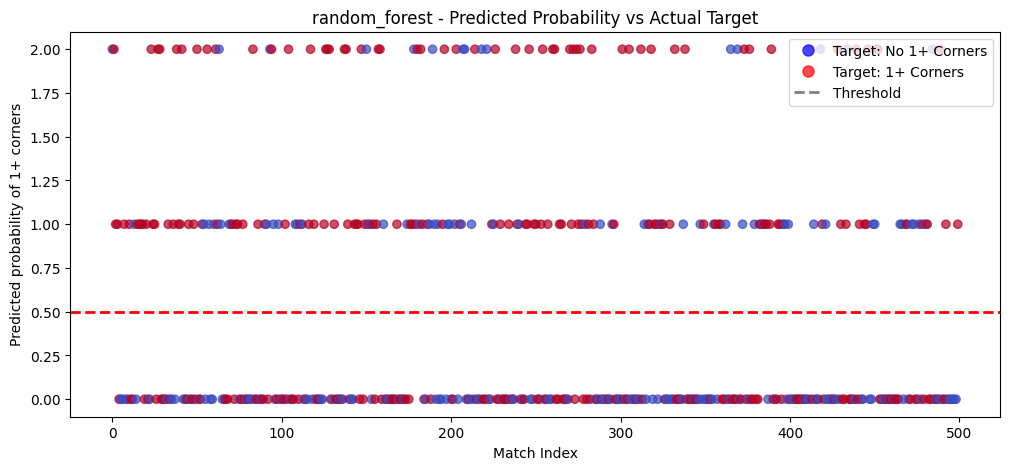


-> Running Backtest...

📊 Betting Trade Summary:
Match ID   Odds       Stake      Profit     Outcome    Bank      
zBEayApd/  1.29       100.00     28.78      1          1028.78   
jLXezZ12/  1.28       102.88     28.92      1          1057.70   
juQ6O2gs/  1.29       105.77     30.80      1          1088.51   
dAz2huli/  1.28       108.85     30.78      1          1119.28   
GtQaVyJb/  1.29       111.93     32.60      1          1151.88   
hQq5vua5/  1.33       115.19     -115.19    0          1036.69   
WWh28JDo/  1.36       103.67     -103.67    0          933.02    
8vNtT32N/  1.29       93.30      27.17      1          960.19    
dKRWhvEb/  1.28       96.02      26.66      1          986.86    
46xLtNWM/  1.28       98.69      27.91      1          1014.76   
WEXi08TC/  1.26       101.48     -101.48    0          913.28    
8fLWJ7IE/  1.28       91.33      25.98      1          939.26    
SzlsIXNm/  1.28       93.93      26.72      1          965.98    
8ljyKuqI/  1.36       96.6

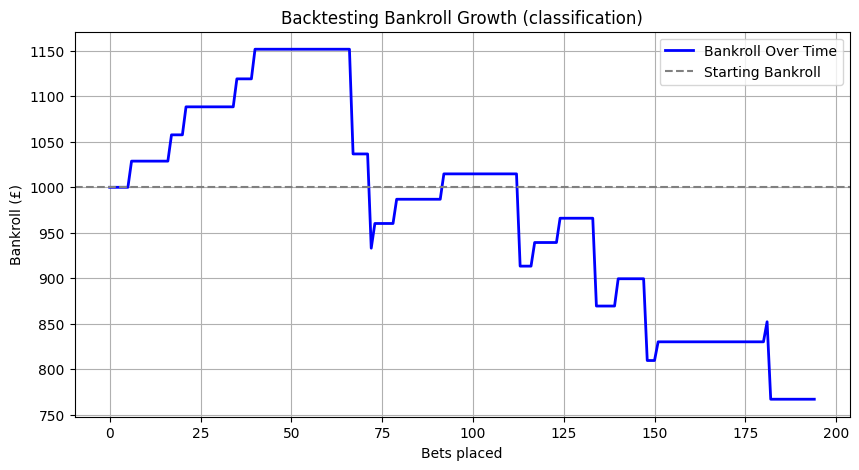

✅ Finished Running Regression Pipeline


In [5]:
run_regression_pipeline(config, df_selected, selected_features, constructed_features, target_variable=target_variable[0], show_output=True, generate_pdf=True)